In [1]:
import os
import sys

import itertools

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from abutils.utils.pipeline import list_files
from abutils.utils.progbar import progress_bar

from pygor.models.genmodel import GenModel
from pygor.models.entropy import compute_models_DKL, compute_event_DKL

# apparently pygor uses a depricated Matplotlib function and produces an insane number of warnings
import warnings
warnings.filterwarnings('ignore')

## Load model data

#### subject-specific models

In [8]:
subject_dirs = list_files('../data_processing/data/subject-specific_models/')

models = []
for s in subject_dirs:
    params = os.path.join(s, 'final_parms.txt')
    marginals = os.path.join(s, 'final_marginals.txt')
    model = GenModel(params, marginals)
    model.subject = os.path.basename(s)
    models.append(model)

#### combined-subject model

In [9]:
combined_model_path = '../data_processing/data/combined_50k_inference/'
params = os.path.join(combined_model_path, 'final_parms.txt')
marginals = os.path.join(combined_model_path, 'final_marginals.txt')
combined_model = GenModel(params, marginals)

#### IGoR's default model

In [6]:
default_model_path = '../data_processing/data/default_IGoR_model/'
params = os.path.join(default_model_path, 'model_parms.txt')
marginals = os.path.join(default_model_path, 'model_marginals.txt')
default_model = GenModel(params, marginals)

## Entropies (complete model)

#### compute pairwise entropy (Kullbeck-Leibler divergence) of the subject-specific models

In [7]:
model_entropies = []
subject_model_entropies = {}

combinations = list(itertools.combinations(models, 2))

for i, (m1, m2) in enumerate(combinations):
    progress_bar(i, len(combinations), extra_info=f'{m1.subject}, {m2.subject}        ')
    e = compute_models_DKL(m1, m2)
    model_entropies.append(e)
    if m1.subject not in subject_model_entropies:
        subject_model_entropies[m1.subject] = {}
    if m2.subject not in subject_model_entropies:
        subject_model_entropies[m2.subject] = {}
    subject_model_entropies[m1.subject][m2.subject] = e
    subject_model_entropies[m2.subject][m1.subject] = e
progress_bar(len(combinations), len(combinations), completion_string='\n')

(45/45) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%  


#### compute the pairwise entropy of each subject-specific model and the default model

In [11]:
default_model_entropies = {}

for i, m in enumerate(models):
    progress_bar(i, len(models), extra_info=f'{m.subject}     ')
    default_model_entropies[m.subject] = compute_models_DKL(m, default_model)
progress_bar(len(models), len(models), completion_string='\n')

(10/10) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%  


#### compute the pairwise entropy of each subject-specific model with the combined-subject model

In [14]:
combined_model_entropies = {}

for i, m in enumerate(models):
    progress_bar(i, len(models), extra_info=f'{m.subject}     ')
    combined_model_entropies[m.subject] = compute_models_DKL(m, combined_model)
progress_bar(len(models), len(models), completion_string='\n')

(10/10) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%  


#### assemble the entropies into a dataframe

In [22]:
entropies = []

for e in model_entropies:
    entropies.append({'entropy': e, 'type': 'subject\nspecific'})
for e in default_model_entropies.values():
    entropies.append({'entropy': e, 'type': 'default'})
for e in combined_model_entropies.values():
    entropies.append({'entropy': e, 'type': 'combined'})
    
entropy_df = pd.DataFrame(entropies)

## Entropies (event-level)

In [17]:
event_renames = {'Deletion_D_gene_Five_prime_prio6_size44': "D-gene trim (5')",
                 'DinucMarkov_VD_genes_Undefined_side_prio3_size16': "DinucMarkov VD",
                 'Deletion_J_gene_Five_prime_prio5_size27': "J-gene trim (5')",
                 'Insertion_DJ_gene_Undefined_side_prio2_size61': "DJ ins length",
                 'Deletion_D_gene_Three_prime_prio6_size44': "D-gene trim (3')",
                 'GeneChoice_J_gene_Undefined_side_prio7_size7': 'J-gene',
                 'Insertion_VD_genes_Undefined_side_prio3_size61': "VD ins length",
                 'GeneChoice_V_gene_Undefined_side_prio8_size97': 'V-gene',
                 'DinucMarkov_DJ_gene_Undefined_side_prio2_size16': 'DinucMarkov DJ',
                 'Deletion_V_gene_Three_prime_prio5_size27': "V-gene trim (3')",
                 'GeneChoice_D_gene_Undefined_side_prio6_size35': 'D-gene'
                }

#### compute event-level entropies for the subject-specific models

In [19]:
subject_event_entopies = []

combinations = list(itertools.combinations(models, 2))

for i, (m1, m2) in enumerate(combinations):
    progress_bar(i, len(combinations), extra_info=f'{m1.subject}, {m2.subject}        ')
    for event in m1.events:
        e = compute_event_DKL(event.name, m1, m2)
        subject_event_entopies.append({'event': event_renames[event.name], 'entropy': e})
progress_bar(len(combinations), len(combinations), completion_string='\n')
        
subject_event_entropy_df = pd.DataFrame(subject_event_entopies)

(45/45) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%  


## Plots

#### complete model entropies

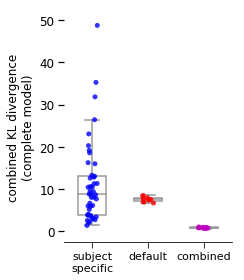

In [20]:
plt.figure(figsize=[3.5, 4])

palette = {'subject\nspecific': 'b', 'default': 'r', 'combined': 'm'}

sns.boxplot(data=entropy_df, x='type', y='entropy', fliersize=0, width=0.5, color='w')
sns.stripplot(data=entropy_df, x='type', y='entropy', jitter=True, palette=palette, alpha=0.8)

plt.xlabel('')
plt.ylabel('combined KL divergence\n(complete model)', fontsize=12)

ax = plt.gca()
ax.tick_params(axis='x', which='major', bottom='on', top='off', direction='out', labelsize=11, length=6)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=4, right=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

#### event-level entropies (subject-specific models)

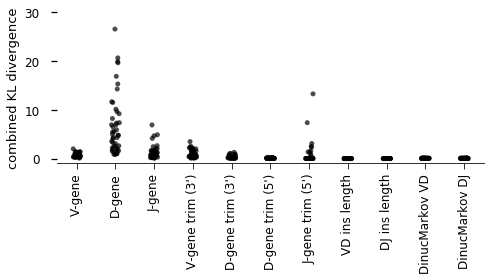

In [21]:
plt.figure(figsize=[7, 4])

sns.stripplot(data=subject_event_entropy_df, x='event', y='entropy', jitter=True, color='k', alpha=0.7)

plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('combined KL divergence', fontsize=13)

plt.ylim([-1, 30])

ax = plt.gca()
ax.tick_params(axis='x', which='major', bottom='on', top='off', direction='out', labelsize=12, length=6)
ax.tick_params(axis='y', which='major', labelsize=12, length=6, width=1.25, pad=12, right=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()